In [1]:
import pickle
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sys
sys.path.append('..')
from utils.util import *
sns.set_theme()
sns.set_style("whitegrid") #  {darkgrid, whitegrid, dark, white, ticks}
sns.set_context("talk")
# sns.set_context("paper")

In [2]:
model_names = ['mlp', 'rnn']
analyze_names = ['calc_ratio', 'analyze_accs', 'analyze_ttest']
ctx_order_strs = {'mlp':[None], 'rnn': ['ctxF', 'ctxL']}
ctx_orders = {'mlp':[None], 'rnn': ['first', 'last']}

anti_ablation = True

if anti_ablation:
    lesion_ps = [1, 10, 30, 50, 70, 90, 500, 1000, 10000] 
    savefig_str_r = 'antiablation_ratio_dists'
    savefig_str_t ='antiablation_ttest_results'
    savefig_str_ra = 'antiablation_ratio_accs'
    savefig_str_cia = 'antiablation_cong_incong_accs'
else:
    lesion_ps = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1] 
    savefig_str_r = 'ablation_ratio_dists'
    savefig_str_t ='ablation_ttest_results'
    savefig_str_ra = 'ablation_ratio_accs'
    savefig_str_cia = 'ablation_cong_incong_accs'

for analyze_name in analyze_names:
    for model_name in model_names:
        for lesion_p in lesion_ps:
            for ctx_order_str in ctx_order_strs[model_name]:
                if ctx_order_str is not None:
                    result_str = '%s_%s_results_%s_lesionp%s.P' %(analyze_name, ctx_order_str, model_name, lesion_p)
                else:
                    result_str = '%s_results_%s_lesionp%s.P' %(analyze_name, model_name, lesion_p)
                with open('../../results/%s' %(result_str), 'rb') as f:
                    model_results = pickle.load(f)
                model_run = dict_to_list(model_results, analyze_name)
                if analyze_name == 'analyze_accs':
                    if ctx_order_str is not None:
                        str_list = '%slesion0%s_acc_runs_%s' %(model_name, int(lesion_p*10), ctx_order_str)
                    else:
                        str_list = '%slesion0%s_acc_runs' %(model_name, int(lesion_p*10))
                    exec("{} = {}".format(str_list, model_run))
                if analyze_name == 'analyze_ttest':
                    val_str = 't_stat_hidd'
                    if ctx_order_str is not None:
                        str_list = 'ttest_hidds_%slesion0%s_%s' %(model_name, int(lesion_p*10), ctx_order_str)
                    else:
                        str_list = 'ttest_hidds_%slesion0%s' %(model_name, int(lesion_p*10))
                    exec("{} = []".format(str_list))
                    exec("{} = np.asarray({})".format(str_list, model_run[val_str]))
                if analyze_name == 'calc_ratio':
                    val_str = 'ratio_hidd'
                    if ctx_order_str is not None:
                        str_list = 'ratio_hidds_%slesion0%s_%s' %(model_name, int(lesion_p*10), ctx_order_str)
                    else:
                        str_list = 'ratio_hidds_%slesion0%s' %(model_name, int(lesion_p*10))
                    exec("{} = []".format(str_list))
                    exec("{} = np.asarray({})".format(str_list, model_run[val_str]))

In [3]:
def runs_to_df(runs_result, ratio_hidds, ttest_hidds, lesion_p):
        cong_train_accs, incong_train_accs = np.asarray(runs_result['cong_train_acc']),\
                                             np.asarray(runs_result['incong_train_acc'])
        ratio_acc_train = cong_train_accs / incong_train_accs
        # ------------
        runs, checkpoints = cong_train_accs.shape
        # ------------
        ratio_hidd = pd.DataFrame(ratio_hidds, columns=np.arange(checkpoints), dtype=np.float) 
        ratio_hidd.insert(0, 'runs', np.arange(runs))
        df_ratio_hidds = pd.melt(ratio_hidd, id_vars=['runs'], var_name='steps', value_name="Ratio Dist. (cong/incong)")
        df_ratio_hidds['Label'] = 'ratio_dist_hidds'
        df_ratio_hidds['Lesion'] = str(lesion_p)
        # ------------
        ttest_hidd = pd.DataFrame(ttest_hidds, columns= np.arange(checkpoints), dtype=np.float)
        ttest_hidd.insert(0, 'runs', np.arange(runs))
        df_ttest_hidds = pd.melt(ttest_hidd, id_vars=['runs'],var_name='steps', value_name='t-values')
        df_ttest_hidds['Label'] = 'tvalues_ttest'
        df_ttest_hidds['Lesion'] = str(lesion_p)
        # ------------
        ratio_tr = pd.DataFrame(ratio_acc_train, columns=np.arange(checkpoints), dtype=np.float) 
        ratio_tr.insert(0, 'runs', np.arange(runs))
        df_ratio_acc_tr = pd.melt(ratio_tr, id_vars=['runs'], var_name='steps', value_name="Ratio Acc. (cong/incong)")
        df_ratio_acc_tr['Label'] = 'ratio_accs_train'
        df_ratio_acc_tr['Lesion'] = str(lesion_p)
        # ------------
        cong_tr = pd.DataFrame(cong_train_accs, columns=np.arange(checkpoints), dtype=np.float) 
        cong_tr.insert(0, 'runs', np.arange(runs))
        df_cong_train = pd.melt(cong_tr, id_vars=['runs'], var_name='steps', value_name="Accuracy")
        df_cong_train['Label'] = 'cong' 
        df_cong_train['Lesion'] = str(lesion_p)
        # ------------
        incong_tr = pd.DataFrame(incong_train_accs, columns=np.arange(checkpoints), dtype=np.float) 
        incong_tr.insert(0, 'runs', np.arange(runs))
        df_incong_train = pd.melt(incong_tr, id_vars=['runs'], var_name='steps', value_name="Accuracy")
        df_incong_train['Label'] = 'incong'
        df_incong_train['Lesion'] = str(lesion_p)
        # ------------
        frames = [df_cong_train, df_incong_train]
        df_acc_train = pd.concat(frames)
        # ------------
        dfs = df_ratio_hidds, df_ratio_acc_tr, df_acc_train, df_ttest_hidds
        # ------------        
        return dfs
        
def concat_dfs(ctx_order, ctx_order_str, model_name, lesion_ps):
    dfs1 = []
    dfs2 = []
    dfs3 = []
    dfs4 = []
    for i, lesion_p in enumerate(lesion_ps):
        if ctx_order is not None:
            ratio_hidds = eval('ratio_hidds_%slesion0%s_%s' %(model_name, int(lesion_p*10), ctx_order_str))
            ttest_hidds = eval('ttest_hidds_%slesion0%s_%s' %(model_name, int(lesion_p*10), ctx_order_str))
            run_res = eval('%slesion0%s_acc_runs_%s' %(model_name, int(lesion_p*10), ctx_order_str))
        else:
            ratio_hidds = eval('ratio_hidds_%slesion0%s' %(model_name, int(lesion_p*10)))
            ttest_hidds = eval('ttest_hidds_%slesion0%s' %(model_name, int(lesion_p*10)))
            run_res = eval('%slesion0%s_acc_runs' %(model_name, int(lesion_p*10)))
        # ------------
        dfs = runs_to_df(run_res, ratio_hidds, ttest_hidds, lesion_p)
        df_ratio_hidds, df_ratio_acc_tr,\
            df_acc_train, df_ttest_hidds = dfs
        # ------------
        dfs1.append(df_ratio_hidds)
        dfs2.append(df_ratio_acc_tr)
        dfs3.append(df_acc_train)
        dfs4.append(df_ttest_hidds)
    dfs_ratio_hidds = pd.concat(dfs1)
    dfs_ratio_acc_tr = pd.concat(dfs2)
    dfs_acc_train = pd.concat(dfs3)
    dfs_ttest_hidds = pd.concat(dfs4)

    return dfs_ratio_hidds, dfs_ratio_acc_tr, dfs_acc_train, dfs_ttest_hidds 

In [4]:
def plot_ratio_dists(df, ctx_order, ctx_order_str, model_str, mfig_str, sub_title, ax, savefig_str):
        mi, mx = 0, 5
        val_name = "Ratio Dist. (cong/incong)"
        
        ax = sns.lineplot(data=df,
                                x="steps", y=val_name, hue="Lesion", palette="flare",
                                marker="o", dashes=False, err_style="bars", ci=68, ax=ax)
        ax.set_ylim([mi, mx])
        ax.set_title(sub_title)
        ax.axhline(y=1, color='r', linewidth=2)        
        if ctx_order is not None:
                fig.suptitle('%s - Ax %s' %(model_str, ctx_order), fontweight='bold', fontsize='25')
        else:
                fig.suptitle('%s' %(model_str), fontweight='bold', fontsize='25')
        plt.legend(loc='upper left', fontsize = '13')
        plt.tight_layout()
        # savefig_str = 'ablation_ratio_dists'
        fig_str = '%s_%s_results_%s' %(ctx_order_str, savefig_str, mfig_str)
        fig.savefig(('../../figures/' + fig_str + '.pdf'), 
                        bbox_inches = 'tight', pad_inches = 0)
        fig.savefig(('../../figures/' + fig_str + '.png'), 
                        bbox_inches = 'tight', pad_inches = 0)  
        return ax

def plot_ttest(df, ctx_order, ctx_order_str, model_str, mfig_str, sub_title, ax, savefig_str):
        threshold = 1.96
        mi, mx = -7, 10
        val_name = "t-values"
        
        ax = sns.lineplot(data=df,
                                x="steps", y=val_name, hue="Lesion", palette="flare",
                                marker="o", dashes=False, err_style="bars", ci=68, ax=ax)
        ax.axhline(y=threshold, color='r', linewidth=2)
        ax.axhline(y=-1*threshold, color='r', linewidth=2)
        ax.set_ylim([mi, mx])
        ax.set_title(sub_title)
        if ctx_order is not None:
                fig.suptitle('%s - Ax %s' %(model_str, ctx_order), fontweight='bold', fontsize='25')
        else:
                fig.suptitle('%s' %(model_str), fontweight='bold', fontsize='25')
        plt.legend(loc='upper left', fontsize = '13')
        plt.tight_layout()
        # savefig_str='ablation_ttest_results'
        fig_str = '%s_%s_%s' %(ctx_order_str, savefig_str, mfig_str)
        fig.savefig(('../../figures/' + fig_str + '.pdf'), 
                        bbox_inches = 'tight', pad_inches = 0)
        fig.savefig(('../../figures/' + fig_str + '.png'), 
                        bbox_inches = 'tight', pad_inches = 0)  
        return ax

def plot_ratio_accs(df, ctx_order, ctx_order_str, model_str, mfig_str, sub_title, ax, savefig_str):
        mi, mx = 0, 5
        val_name = "Ratio Acc. (cong/incong)"
        
        ax = sns.lineplot(data=df,
                                x="steps", y=val_name, hue="Lesion", palette="flare", 
                                marker='o', dashes=False, err_style="bars", ci=68, ax=ax)
        ax.axhline(y=1, color='r', linewidth=2)        
        ax.set_ylim([mi, mx])
        ax.set_title(sub_title)
        if ctx_order is not None:
                fig.suptitle('%s - Ax %s' %(model_str, ctx_order), fontweight='bold', fontsize='25')
        else:
                fig.suptitle('%s' %(model_str), fontweight='bold', fontsize='25')
        plt.legend(loc='upper left', fontsize = '13')
        plt.tight_layout()
        # savefig_str = 'ablation_ratio_accs'
        fig_str = '%s_%s_results_%s' %(ctx_order_str, savefig_str, mfig_str)
        fig.savefig(('../../figures/' + fig_str + '.pdf'), 
                        bbox_inches = 'tight', pad_inches = 0)
        fig.savefig(('../../figures/' + fig_str + '.png'), 
                        bbox_inches = 'tight', pad_inches = 0)
        return ax

def plot_cong_incong_accs(df, ctx_order, ctx_order_str, model_str, mfig_str, sub_title, ax, savefig_str):
        mi, mx = 0, 2
        val_name = "Accuracy"
        ax = sns.lineplot(data=df,
                    x="steps", y=val_name, hue="Lesion", style='Label', palette="flare", 
                    markers=True, dashes=False, err_style="bars",  ci=68, ax=ax)
        ax.set_ylim([mi, mx])
        ax.set_title(sub_title)  

        if ctx_order is not None:
                fig.suptitle('%s - Ax %s' %(model_str, ctx_order), fontweight='bold', fontsize='25')
        else:
                fig.suptitle('%s' %(model_str), fontweight='bold', fontsize='25')
        plt.legend(loc='upper left', fontsize = '13')
        plt.tight_layout()
        # savefig_str = 'ablation_cong_incong_accs'
        fig_str = '%s_%s_results_%s' %(ctx_order_str, savefig_str, mfig_str)
        fig.savefig(('../../figures/' + fig_str + '.pdf'), 
                        bbox_inches = 'tight', pad_inches = 0)
        fig.savefig(('../../figures/' + fig_str + '.png'), 
                        bbox_inches = 'tight', pad_inches = 0)

        return ax



# RNN

In [5]:
figx, figy = 12, 6

# Lesioned RNN

## Axis First

In [6]:
ctx_order, ctx_order_str, model_str, mfig_str, sub_title = 'first', 'ctxF', 'Lesioned RNN', 'rnnlesionall', ''
model_name = 'rnn'
    
dfs_ratio_hidds, dfs_ratio_acc_tr, dfs_acc_train, dfs_ttest_hidds = \
    concat_dfs(ctx_order, ctx_order_str, model_name, lesion_ps)

In [7]:
np.unique(dfs_ratio_hidds['Lesion'])

array(['1', '10', '1000', '10000', '30', '50', '500', '70', '90'],
      dtype=object)

<AxesSubplot:xlabel='steps', ylabel='Ratio Dist. (cong/incong)'>

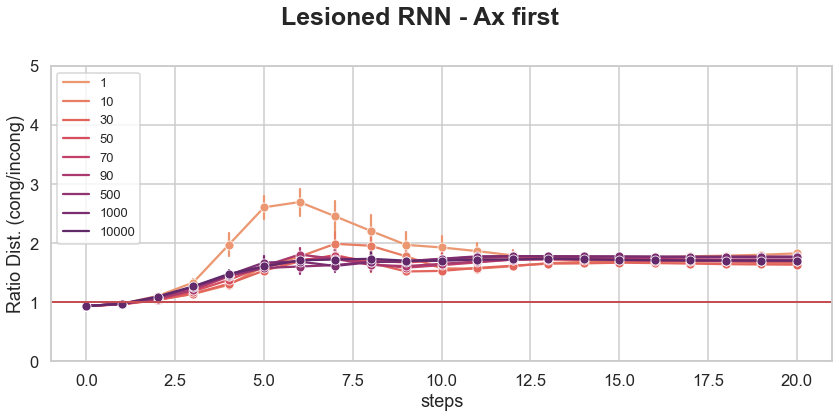

In [8]:
fig, ax = plt.subplots(figsize=(figx,figy))
plot_ratio_dists(dfs_ratio_hidds, ctx_order, ctx_order_str, model_str, mfig_str, sub_title, ax, savefig_str_r)

<AxesSubplot:xlabel='steps', ylabel='t-values'>

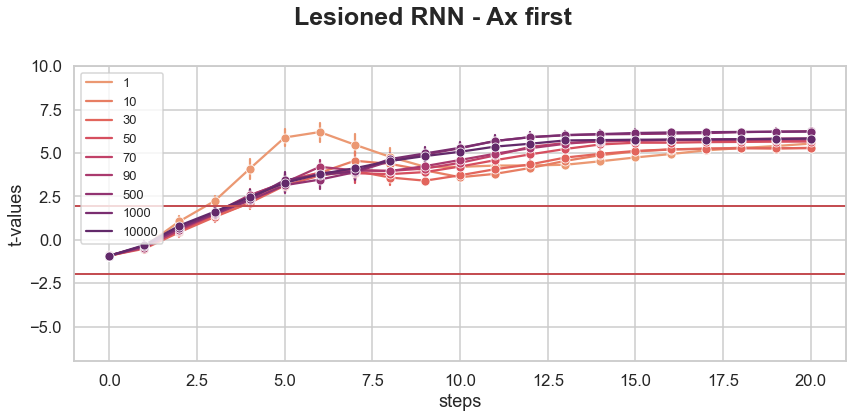

In [9]:
fig, ax = plt.subplots(figsize=(figx,figy))
plot_ttest(dfs_ttest_hidds, ctx_order, ctx_order_str, model_str, mfig_str, sub_title, ax, savefig_str_t)

<AxesSubplot:xlabel='steps', ylabel='Ratio Acc. (cong/incong)'>

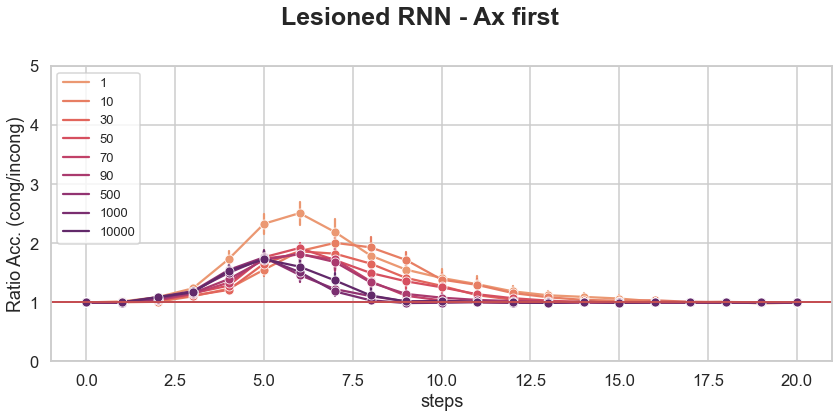

In [10]:
fig, ax = plt.subplots(figsize=(figx,figy))
plot_ratio_accs(dfs_ratio_acc_tr, ctx_order, ctx_order_str, model_str, mfig_str, sub_title, ax, savefig_str_ra)

<AxesSubplot:xlabel='steps', ylabel='Accuracy'>

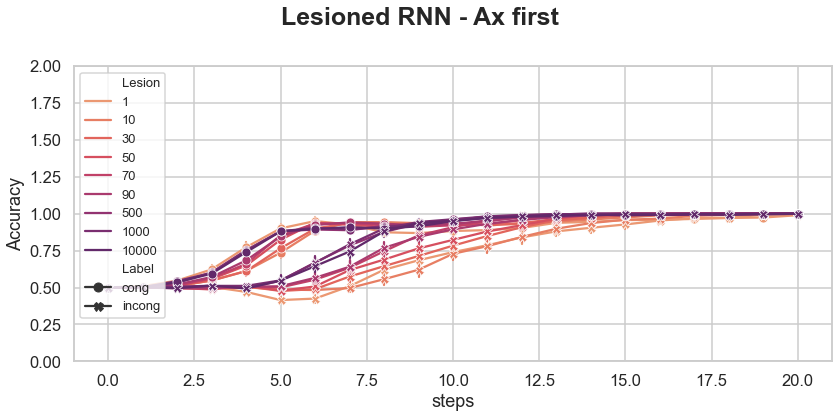

In [11]:
fig, ax = plt.subplots(figsize=(figx,figy))
plot_cong_incong_accs(dfs_acc_train, ctx_order, ctx_order_str, model_str, mfig_str, sub_title, ax, savefig_str_cia)

## Ax last

In [12]:
ctx_order, ctx_order_str, model_str, mfig_str, sub_title = 'last', 'ctxL', 'Lesioned RNN', 'rnnlesionall', ''
model_name = 'rnn'
# lesion_ps = [0.1, 0.3, 0.5, 0.7, 0.9]
dfs_ratio_hidds, dfs_ratio_acc_tr, dfs_acc_train, dfs_ttest_hidds = \
    concat_dfs(ctx_order, ctx_order_str, model_name, lesion_ps)

<AxesSubplot:xlabel='steps', ylabel='Ratio Dist. (cong/incong)'>

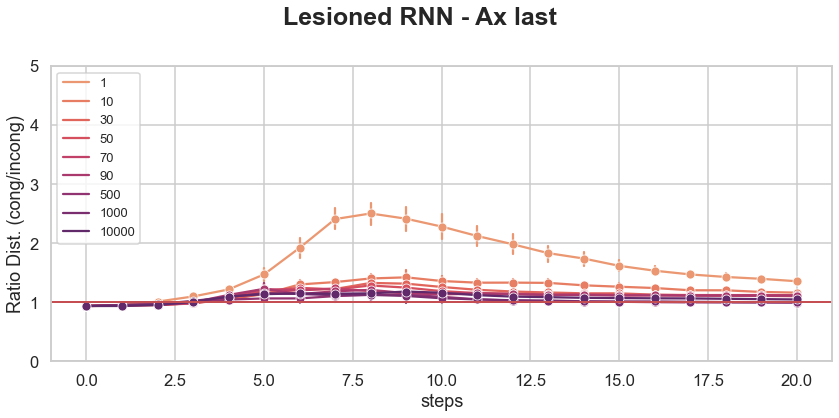

In [13]:
fig, ax = plt.subplots(figsize=(figx,figy))
plot_ratio_dists(dfs_ratio_hidds, ctx_order, ctx_order_str, model_str, mfig_str, sub_title, ax, savefig_str_r)

<AxesSubplot:xlabel='steps', ylabel='t-values'>

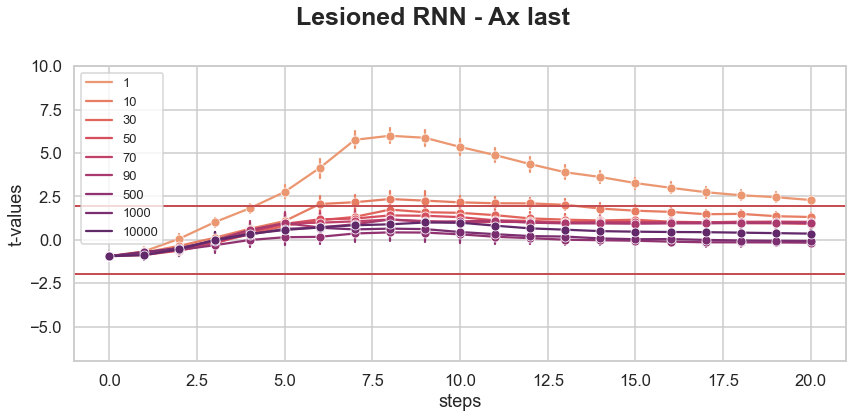

In [14]:
fig, ax = plt.subplots(figsize=(figx,figy))
plot_ttest(dfs_ttest_hidds, ctx_order, ctx_order_str, model_str, mfig_str, sub_title, ax, savefig_str_t)

<AxesSubplot:xlabel='steps', ylabel='Ratio Acc. (cong/incong)'>

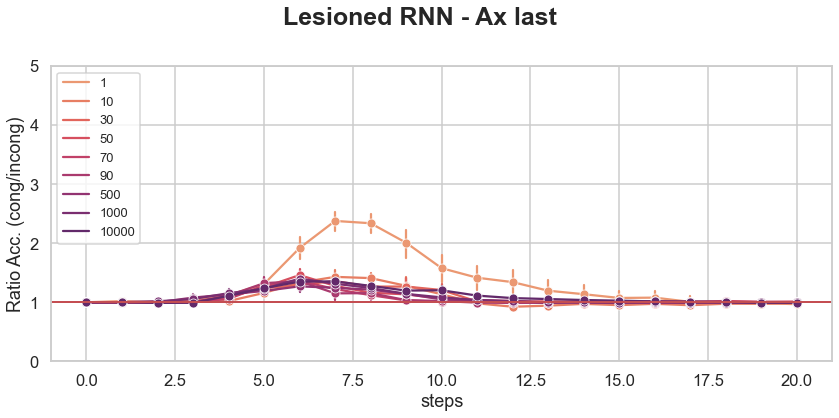

In [15]:
fig, ax = plt.subplots(figsize=(figx,figy))
plot_ratio_accs(dfs_ratio_acc_tr, ctx_order, ctx_order_str, model_str, mfig_str, sub_title, ax, savefig_str_ra)

<AxesSubplot:xlabel='steps', ylabel='Accuracy'>

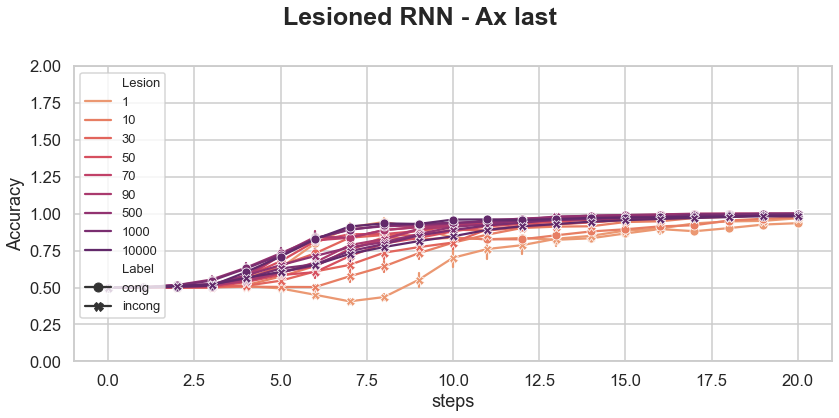

In [16]:
fig, ax = plt.subplots(figsize=(figx,figy))
plot_cong_incong_accs(dfs_acc_train, ctx_order, ctx_order_str, model_str, mfig_str, sub_title, ax, savefig_str_cia)

# MLP

In [17]:
ctx_order, ctx_order_str, model_str, mfig_str, sub_title = None, None, 'Lesioned MLP', 'mlplesionall', ''
model_name = 'mlp'
# lesion_ps = [0.1, 0.3, 0.5, 0.7, 0.9]
dfs_ratio_hidds, dfs_ratio_acc_tr, dfs_acc_train, dfs_ttest_hidds = \
    concat_dfs(ctx_order, ctx_order_str, model_name, lesion_ps)

<AxesSubplot:xlabel='steps', ylabel='Ratio Dist. (cong/incong)'>

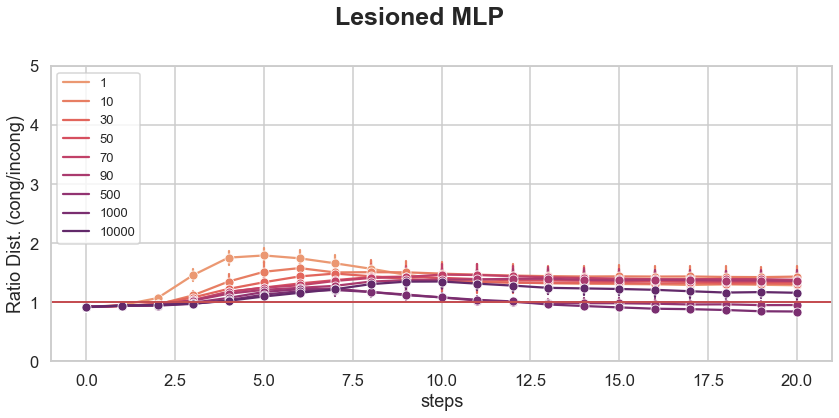

In [18]:
fig, ax = plt.subplots(figsize=(figx,figy))
plot_ratio_dists(dfs_ratio_hidds, ctx_order, ctx_order_str, model_str, mfig_str, sub_title, ax, savefig_str_r)

<AxesSubplot:xlabel='steps', ylabel='t-values'>

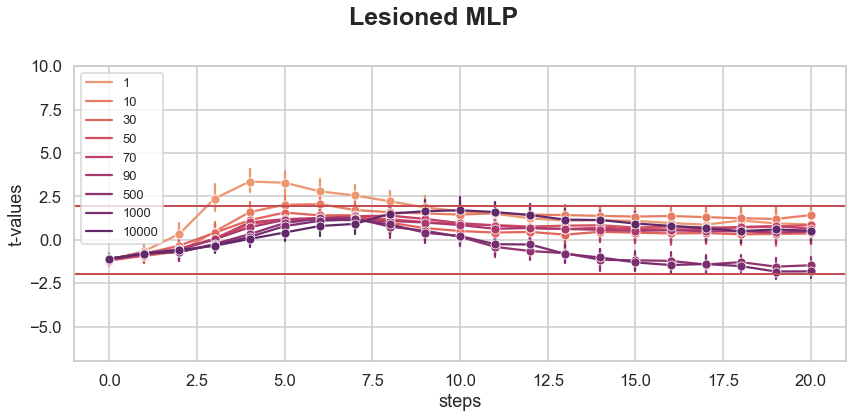

In [19]:
fig, ax = plt.subplots(figsize=(figx,figy))
plot_ttest(dfs_ttest_hidds, ctx_order, ctx_order_str, model_str, mfig_str, sub_title, ax, savefig_str_t)

<AxesSubplot:xlabel='steps', ylabel='Ratio Acc. (cong/incong)'>

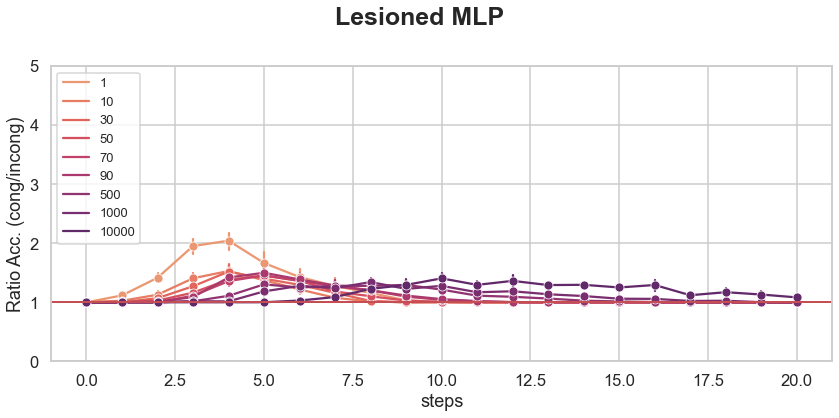

In [20]:
fig, ax = plt.subplots(figsize=(figx,figy))
plot_ratio_accs(dfs_ratio_acc_tr, ctx_order, ctx_order_str, model_str, mfig_str, sub_title, ax, savefig_str_ra)

<AxesSubplot:xlabel='steps', ylabel='Accuracy'>

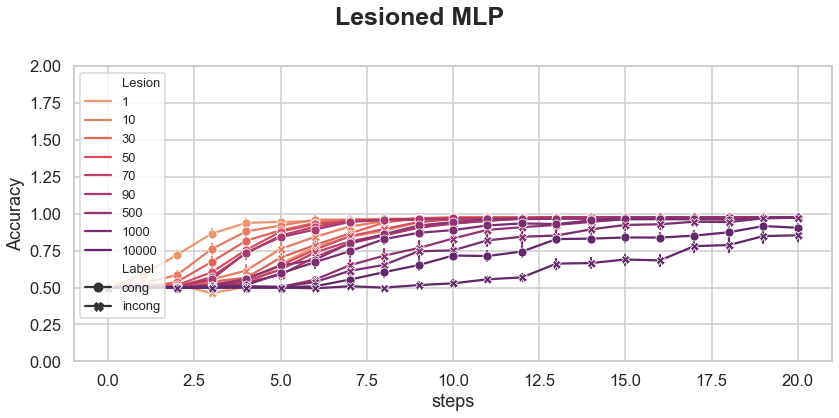

In [21]:
fig, ax = plt.subplots(figsize=(figx,figy))
plot_cong_incong_accs(dfs_acc_train, ctx_order, ctx_order_str, model_str, mfig_str, sub_title, ax, savefig_str_cia)